In [19]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras import callbacks
from tensorflow.keras.layers import TextVectorization
from datetime import datetime
import matplotlib.pyplot as plt

### Data Preprocessing ###

In [2]:
def preprocess_for_tfrecord(tfrecord):
    """ preprocess for reading
    """
    feature_descriptions = {
        "review": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "sentiment": tf.io.FixedLenFeature([], tf.int64, default_value=0)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    return example["review"], example["sentiment"]

def load_tfrecord(filepaths, n_read_threads=5, shuffle_buffer_size=10000,
                n_parse_threads=5, batch_size=32, cache=True):
    """ first convert the filepath into tfdataset, then shuffle the files
        then reading the data from files
        by using prefetch in -> make faster (prepare the next data even the current data not finishes)"""
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess_for_tfrecord, num_parallel_calls=n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)      

def list_files_in_path(pathfile):
    files = []
    for file in os.listdir(pathfile):
        files.append(os.path.join(pathfile,file))
    return files


In [4]:
train_set = load_tfrecord(list_files_in_path("datasets\\tfrecords\\train"))
valid_set = load_tfrecord(list_files_in_path("datasets\\tfrecords\\validation"))

### Text Vectorization ###

In [5]:
"""you can change the following parameters
    One can also use the Keras Tuner to tune the embedding dim"""
num_of_words = 10000
max_sentence_len = 200
embedding_dim = 16

In [6]:
text_vectorize_dict = {
    "max_tokens": num_of_words,
    "output_mode": "int",
    "output_sequence_length":max_sentence_len
}

In [7]:
vectorize_layer = TextVectorization(**text_vectorize_dict)
vectorize_layer._name="Text_Vectorization_Layer"

In [8]:
vectorize_layer.adapt(train_set.map(lambda x,y: x))

### USE KERAS TUNER ###
We find the optimal parameters in our set

In [ ]:
def model_tuner(hp):
    model = Sequential()
    model.add(vectorize_layer)
    model.add(layers.Embedding(input_dim=num_of_words,output_dim=embedding_dim,
                                input_length=max_sentence_len,name="Embedding_layer"))
    conv1_filters = hp.Choice("conv1_filters",values=[16,32,64,128])
    conv1_kernels = hp.Choice("conv1_kernels",values=[3,5,7,9,11])
    model.add(layers.Conv1D(filters=conv1_filters,kernel_size=conv1_kernels,
                            activation='selu',kernel_initializer='lecun_normal'))
    model.add(layers.GlobalAveragePooling1D())
    dense_1_units = hp.Int('dense_1_units', min_value=6, max_value=10, step=1)
    model.add(layers.Dense(units=dense_1_units,activation='selu',kernel_initializer='lecun_normal'))
    model.add(layers.Dense(1, activation='sigmoid'))
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss="BinaryCrossentropy",metrics=['accuracy'],optimizer=Adam(learning_rate=learning_rate))
    return model

In [ ]:
tuner = kt.Hyperband(model_tuner,objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='movie_reviews')
early_stopping = callbacks.EarlyStopping(monitor="val_loss",patience=5)

In [ ]:
tuner.search(train_set,epochs=50,validation_data=valid_set,callbacks=[early_stopping])

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
the hyperparameter search is complete. The optimal numbers of parameters are
conv1_filters: {best_hps.get("conv1_filters")}
conv1_kernels: {best_hps.get("conv1_kernels")}
dense_1_units: {best_hps.get("dense_1_units")}
learning_rate: {best_hps.get("learning_rate")}
""")

the best parameter for the search are:
conv1_filters: 64
conv1_kernels: 3
dense_1_units: 9
learning_rate: 0.01

In [ ]:
model = tuner.hypermodel.build(best_hps)

### Train the model ###

In [15]:

tf_board_dir = "logs/train_tf_board/"+datetime.now().strftime("%Y%m%d--%H%M%S")
check_point_dir = "logs/check_point"

tensorboard_callback = callbacks.TensorBoard(log_dir=tf_board_dir)
early_stopping = callbacks.EarlyStopping(monitor="val_loss",patience=10)
check_point = callbacks.ModelCheckpoint(filepath=check_point_dir,
                                        monitor="val_loss",
                                        save_best_only=True,
                                        save_weights_only=True)


In [13]:
def scheduler(epoch, lr):
    return lr*0.5**(epoch//10)
learning_rate_scheduler =callbacks.LearningRateScheduler(scheduler)

In [10]:
"""If you use the model which we find by using keras
     tuner then you do not need to do run this cell"""
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    vectorize_layer,
    layers.Embedding(input_dim=num_of_words,output_dim=16,input_length=max_sentence_len),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(9, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
model.compile(loss="BinaryCrossentropy",metrics=['accuracy'],optimizer=Adam(0.01))

In [17]:
history = model.fit(train_set,
            epochs=100,
            batch_size=32,
            validation_data=valid_set,
            callbacks=[early_stopping,
                    check_point,
                    learning_rate_scheduler,
                    tensorboard_callback]
            )

Epoch 1/100
1250/1250 [==============================] - 19s 13ms/step - loss: 0.3585 - accuracy: 0.8429 - val_loss: 0.2894 - val_accuracy: 0.8778 - lr: 0.0100
Epoch 2/100
1250/1250 [==============================] - 12s 10ms/step - loss: 0.2311 - accuracy: 0.9083 - val_loss: 0.2967 - val_accuracy: 0.8742 - lr: 0.0100
Epoch 3/100
1250/1250 [==============================] - 13s 10ms/step - loss: 0.1835 - accuracy: 0.9294 - val_loss: 0.3262 - val_accuracy: 0.8710 - lr: 0.0100
Epoch 4/100
1250/1250 [==============================] - 14s 11ms/step - loss: 0.1392 - accuracy: 0.9492 - val_loss: 0.4241 - val_accuracy: 0.8610 - lr: 0.0100
Epoch 5/100
1250/1250 [==============================] - 16s 13ms/step - loss: 0.1022 - accuracy: 0.9646 - val_loss: 0.4610 - val_accuracy: 0.8590 - lr: 0.0100
Epoch 6/100
1250/1250 [==============================] - 16s 13ms/step - loss: 0.0758 - accuracy: 0.9735 - val_loss: 0.5268 - val_accuracy: 0.8448 - lr: 0.0100
Epoch 7/100
1250/1250 [=================

In [18]:
model.load_weights(check_point_dir)

### Plot the Training Data ###

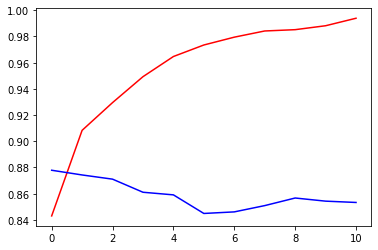

In [24]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(np.arange(len(train_acc)),train_acc,"r",label="training accuracy")
plt.plot(np.arange(len(val_acc)),val_acc,"b",label="validation accuracy")


**Anlayse**

It looks like our model has overfitten the training data.
What can we do? So first we can collect more data. 
But we can also add a dropout layer.

If this wont work out we cann try GRU or LSTM layer, since the training for LSTM take longer I will not use it here.

But now let look at the test set

In [26]:
test_set = load_tfrecord(list_files_in_path("datasets\\tfrecords\\test"))

In [71]:
def return_accuracy(test_set):
    accuracy = tf.keras.metrics.Accuracy()
    for x,y in test_set.map(lambda x,y: (x,y)):
        accuracy.update_state(y,model.predict(x)>0.5)
    return accuracy.result()


In [72]:
return_accuracy(test_set=test_set)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8752>

So we get 87.5% accuracy on the test set!

In [73]:
model.save("saved_model/model")

INFO:tensorflow:Assets written to: saved_mdoel/model\assets


INFO:tensorflow:Assets written to: saved_mdoel/model\assets
